In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshmahee","key":"43f2213a6e91296bdd9c20808afed440"}'}

In [2]:
import os
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
 99% 1.49G/1.52G [00:10<00:00, 249MB/s]
100% 1.52G/1.52G [00:10<00:00, 158MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Conv2D, BatchNormalization,Dense,MaxPooling2D,Flatten,Dropout,Activation
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array

In [6]:
df = pd.read_csv('/content/kidneyData.csv')

In [7]:
base_path = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"


df["image_id"] = df["image_id"].str.strip()

df["path"] = df.apply(lambda row: os.path.join(base_path, row["Class"], row["image_id"] + ".jpg"), axis=1)


print(df["path"].head())

0    /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...
1    /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...
2    /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...
3    /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...
4    /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...
Name: path, dtype: object


In [8]:
from PIL import Image

for path in df['path'].head(5):
    if os.path.exists(path):
        img = Image.open(path)
        img.show()
    else:
        print("❌ File not found:", path)

In [9]:
df = df[['path','Class']]

In [10]:
base_dir = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

In [11]:
count = df['Class'].value_counts()
count

,count
Class,
Normal,5077
Cyst,3709
Tumor,2283
Stone,1377


/tmp/ipython-input-3159053284.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index,y=count.values,palette='viridis')


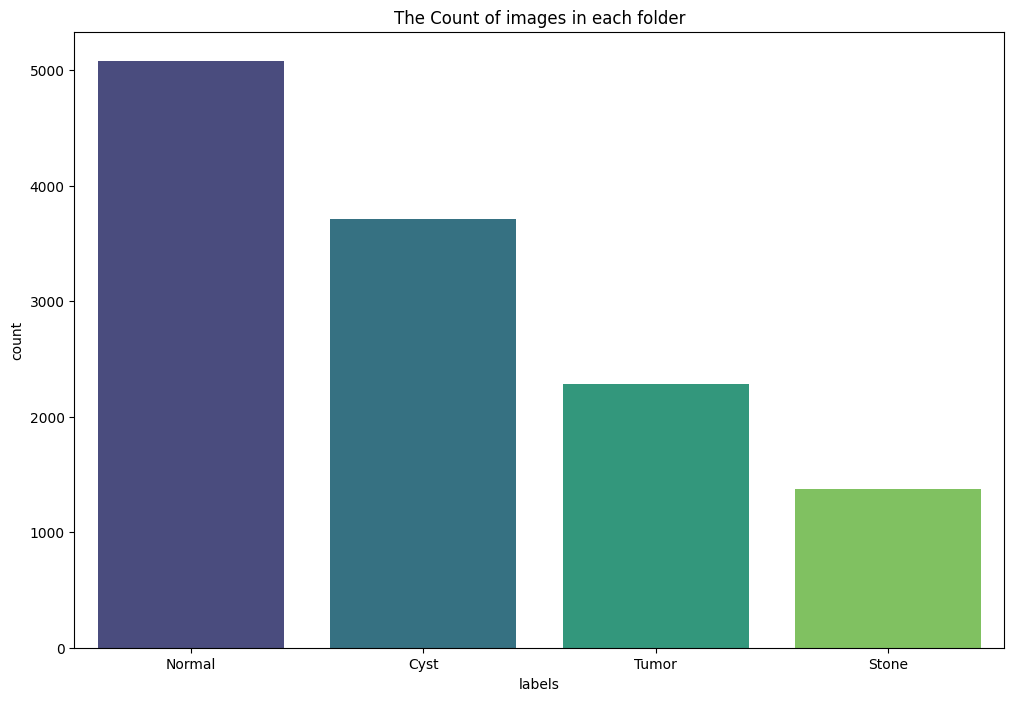

In [12]:
plt.figure(figsize=(12,8))
sns.barplot(x=count.index,y=count.values,palette='viridis')
plt.title('The Count of images in each folder')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

In [13]:
strat=df['Class']
train_df ,dummy_df=train_test_split(df,test_size=0.3,random_state=42,stratify=strat)
strate=dummy_df['Class']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

In [14]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(8712, 2)
(1867, 2)
(1867, 2)


In [15]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' )
ts_gen=ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'path', y_col= 'Class', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'path', y_col= 'Class', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'path', y_col= 'Class', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8712 validated image filenames belonging to 4 classes.
Found 1867 validated image filenames belonging to 4 classes.
Found 1867 validated image filenames belonging to 4 classes.


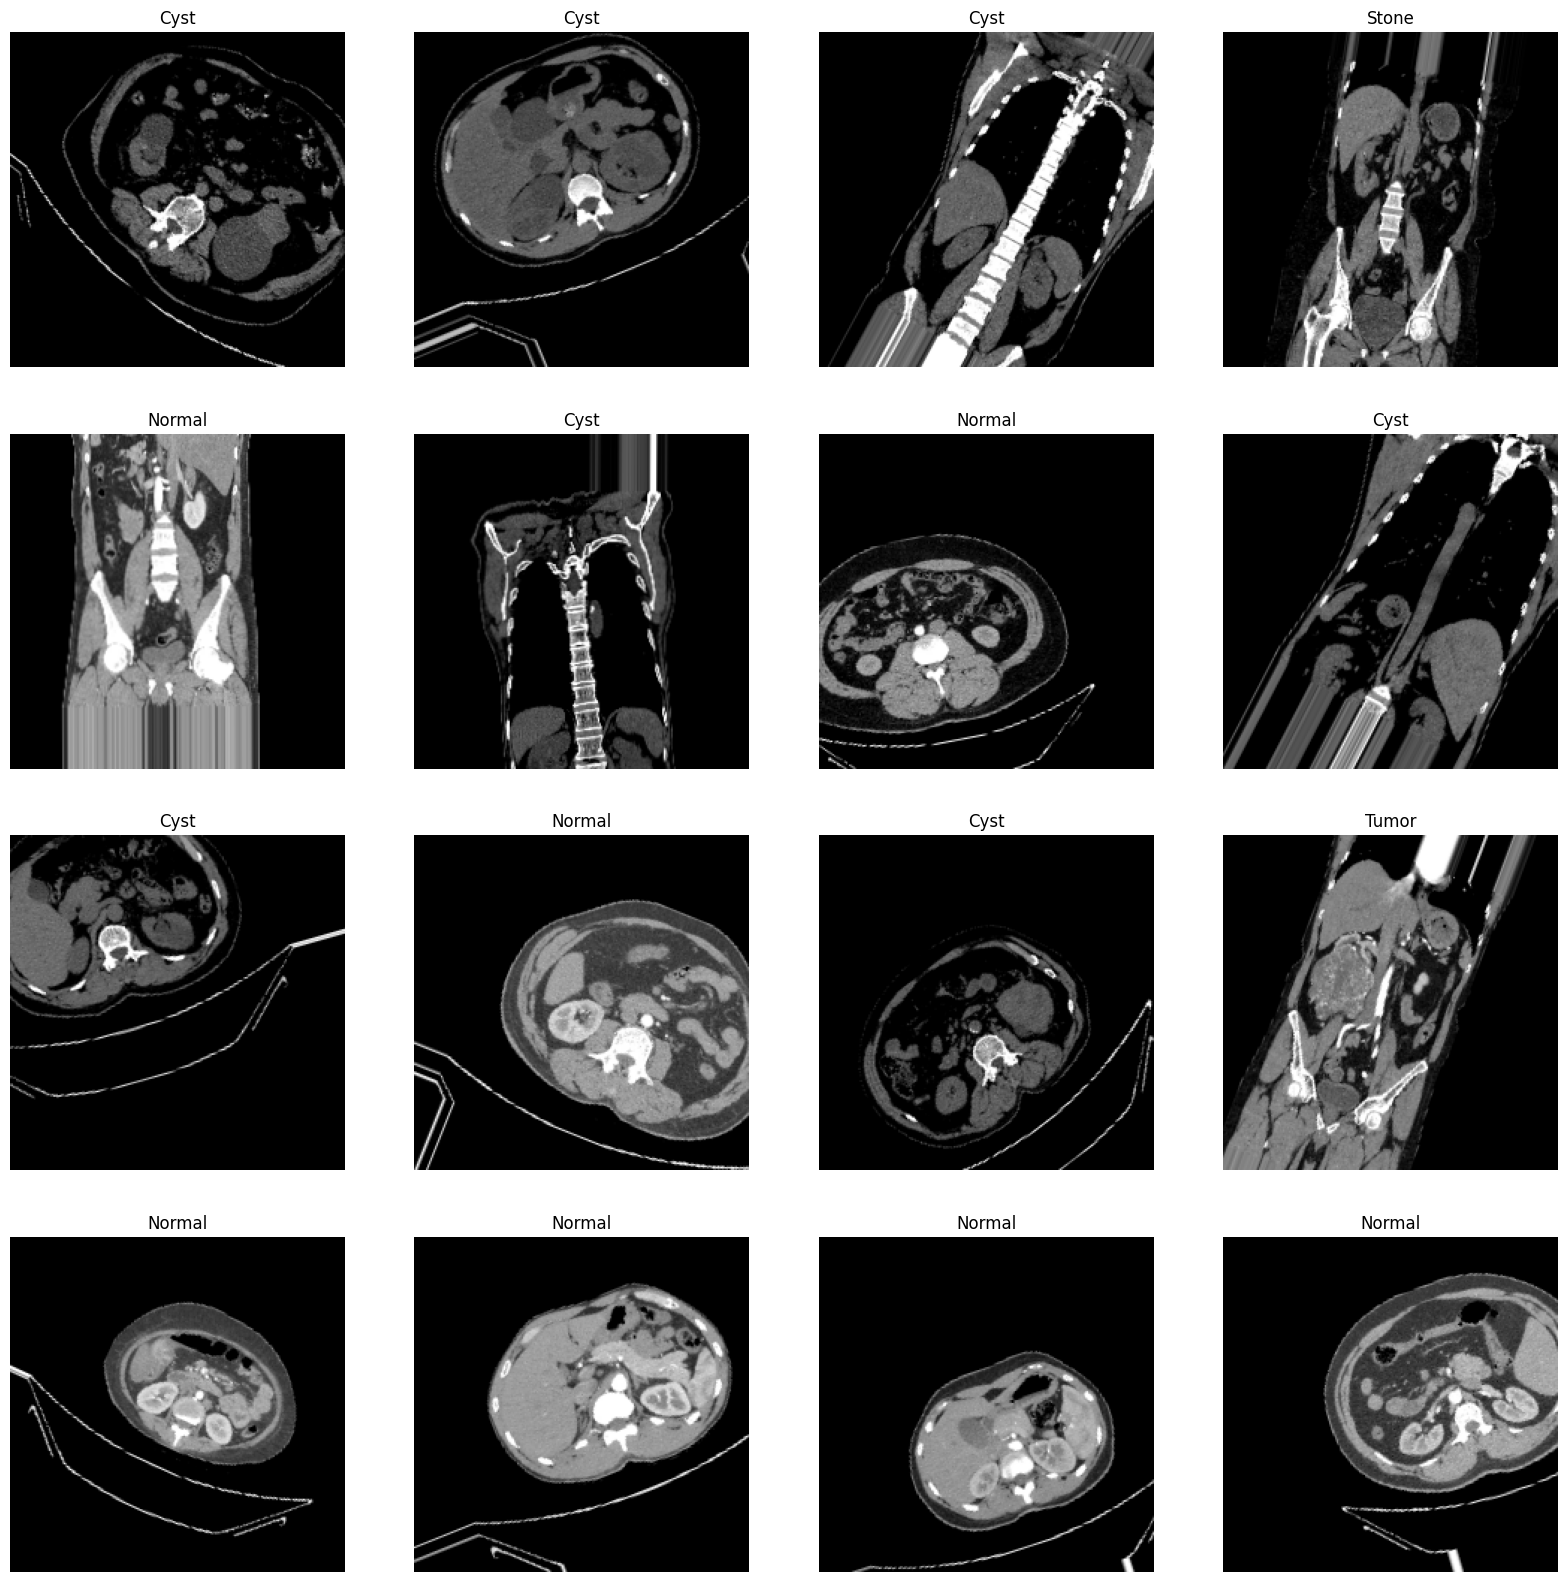

In [16]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

In [17]:
base_model=keras.applications.EfficientNetB0(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.compile(Adamax(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,139,559 (76.83 MB)

 Trainable params: 20,097,536 (76.67 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [19]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history=model.fit(train_gen,epochs=100,validation_data=valid_gen,shuffle=False,
                    callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.6483 - loss: 0.9232 - val_accuracy: 0.5726 - val_loss: 0.9900
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.8551 - loss: 0.3863 - val_accuracy: 0.6481 - val_loss: 0.8790
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.9131 - loss: 0.2433 - val_accuracy: 0.6422 - val_loss: 0.9763
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9388 - loss: 0.1754 - val_accuracy: 0.6577 - val_loss: 1.0327
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9601 - loss: 0.1220 - val_accuracy: 0.8018 - val_loss: 0.6069
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9624 - loss: 0.1056 - val_accuracy: 0.8548 - val_loss: 0.5492
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9717 - loss: 0.0829 - val_accuracy: 0.9089 - val_loss: 0.3243
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9777 - loss: 0.0703 - 

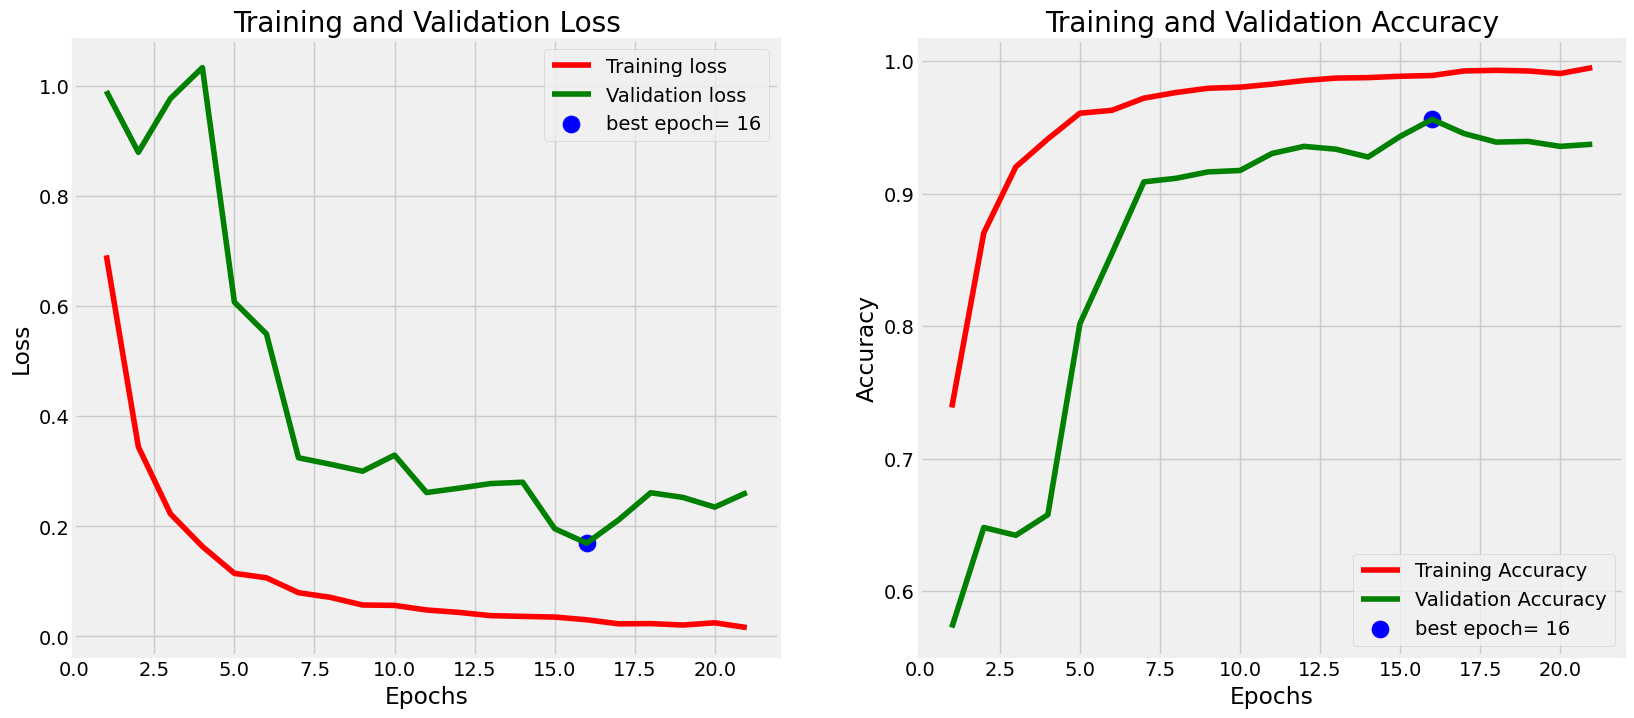

In [20]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [21]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 138s 74ms/step - accuracy: 0.9982 - loss: 0.0058


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1867/1867 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9560 - loss: 0.1693    


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1867/1867 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9485 - loss: 0.2090    
Train Loss:  0.005840495228767395
Train Accuracy:  0.9981634616851807
--------------------
Valid Loss:  0.16932247579097748
Valid Accuracy:  0.9560792446136475
--------------------
Test Loss:  0.20866192877292633
Test Accuracy:  0.9485806226730347


In [22]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 514ms/step


In [23]:
model.save('kidney_classification.h5')

In [24]:
img_path = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1899).jpg"

In [25]:
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

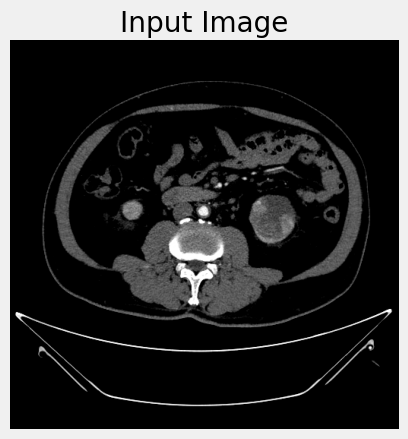

In [26]:
img = Image.open(img_path).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

In [27]:
img = img.resize((224,224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

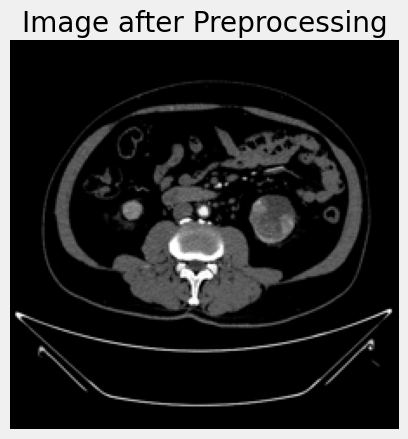

In [28]:
plt.imshow(img_array[0])  # Show after preprocessing
plt.title("Image after Preprocessing")
plt.axis('off')
plt.show()

In [29]:
pred = model.predict(img_array)
probabilities = pred[0]
predicted_class_index = np.argmax(probabilities)
predicted_class = class_names[predicted_class_index]

# Display prediction
print("🔍 Predicted class:", predicted_class)
print("📊 All probabilities:")
for i, (cls, prob) in enumerate(zip(class_names, probabilities)):
    print(f"  {cls}: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
🔍 Predicted class: Cyst
📊 All probabilities:
  Cyst: 0.8298
  Normal: 0.0387
  Stone: 0.0979
  Tumor: 0.0336
